## Estimação da Curva de Potência com Regressão Polinomial usando Global Random Search para estimar os coeficientes

Os modelos de regressão linear polinomial são usados, em geral, como funções aproximadoras, e a equação de regressão é ajustada ao conjunto de dados em questão [1]. O modelo matemático formulado para representação dos dados é dito linear se obedece a seguinte equação [1]:

$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \varepsilon 
$$

Onde $\beta_0$ é o intercepto e $\beta_1$, $\beta_2$, $\beta_3$ são os coeficientes de regressão associados às variáveis preditoras. $\varepsilon$ é o termo de erro aleatório.

No caso da equação acima, a equação é de grau 3, porém o grau do polinômio descritor é da ordem da quantidade de variáveis regressoras do problema em questão.

Para essa implementação, os coeficientes foram encontrados por meio do algoritmo Busca Aleatória Global (*Global Random Search), ou GRS, que consiste em inicializar várias soluções aleatoriamente e escolher a melhor dentre elas [2]. É um método estocástico já que tem geração aleatória e cada iteração do algoritmo é independente entre si. Também é considerada uma heurística por não derivar de princípios matemáticos formais.

### Sobre o modelo
Foram gerados 10 modelos regressores polinomiais, um para cada grau a partir do 1º. Para cada grau acima do primeiro, foi feita a transformação polinomial (elevação dos valores ao grau do polinômio) do vetor de dados de velocidade, para que fique da dimensão do respectivo grau. Para o grau 1, apenas foi acrescido uma coluna de 1's (vetor de *bias*). 

Para o GRS, usou-se 5 realizações, com 100.000 iterações para a convergência do modelo e taxa de aprendizado de 0.9. Cada rodada de realizações foram feitas para todos os graus do polinômio, do 1 ao 10, e foram salvos os coeficientes resultantes de cada realização, assim como as métricas: R2, R2 Ajustado e AIC, como na questão anterior. Por fim, para cada grau, selecionou-se os 3 melhores modelos gerados, com base no valor de R2. O erro usado como função-custo a ser minimizado a cada iteração foi o erro médio quadrático (MSE).

### Sobre o dataset
O *dataset* utilizado é um dataset de dados de Potência de um aerogerador em função da sua velocidade. São um total de 2250 dados e, por ter apenas uma variável regressora, esse é um modelo originalmente de ordem 1.

### Resultados
No caso dessa implementação, os graus 4 e 5 são os que a curva melhor se adequa aos dados, sendo a melhor execução de ambos os graus as que possuem o maior R2 entre todas as curvas observadas (R2 e R2 ajustado de cerca de 0.97 cada, e um AIC de 30100-30200). No entanto, diferente da questão anterior (usando MQO e MQR), para graus maiores que 5, a curva passa a não mais convergir e "fugir" dos dados. Isso pode ocorrer pelo baixo número de iterações no treinamento para aquela grande quantidade de dados, não chegando na convergência do modelo.

As curvas de predição dos 3 melhores modelos de regressão para cada grau do polinômio sobrepostas aos dados reais podem ser vistas nas imagens abaixo.

**Os valores dos coeficientes obtidos via GRS/LRS coincidem com os obtidos pelo método OLS?**

Em parte. Para polinômios até grau 5 as curvas ficam parecidas (coeficientes próximos), mas para graus mais elevados, as curvas cujos coeficientes foram formados através do GRS passam a divergir dos dados, não se adequando ao *dataset*.

**O resultado final (i.e. valores dos coeficientes) é sempre o mesmo para diferentes rodadas/repetições dos métodos GRS/LRS?**

Não, apesar de em alguns casos ser parecido, inclusive os critérios serem da mesma ordem, as diferentes rodadas para o GRS formulam diferentes modelos, com diferentes coeficientes. Isso pode ser visto pela própria curva de predição, que possui diferentes inclinações para diferentes execuções de um mesmo grau.

**Referências:**
1. HINES, W. W. et al. *Probabilidade e Estatística na Engenharia*. Quarta. [S.l.]: LTC, 2006.
2. ZHIGLJAVSKY, Anatoly A. Theory of global random search. Springer Science & Business Media, 2012.2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Carregando dataset
dataset = np.loadtxt("dataset/aerogerador.dat")
dataset

array([[  0. ,   0. ],
       [  0. ,   0. ],
       [  0. ,   0. ],
       ...,
       [ 14.1, 508. ],
       [ 14.3, 508. ],
       [ 14.4, 503. ]])

In [2]:
vel = dataset[:, 0]  # Velocidades
Pot = dataset[:, 1]  # Potências

vel.shape, Pot.shape

((2250,), (2250,))

In [3]:
from sklearn.metrics import r2_score

def criteria_metrics(type, y_true, y_pred, X, num_coeff):
    if type == "R2":
        return r2_score(y_true, y_pred)
    elif type == "Adj_R2":
        return 1 - (1 - r2_score(y_true, y_pred)) * ((len(y_true) - 1) / (len(y_true) - X.shape[1] - 1))
    elif type == "AIC":
        res = y_true - y_pred
        sum_res = np.sum(res**2)
        return len(y_true) * np.log(sum_res) + 2 * num_coeff

def polynomial_matrix(k, X):
    if k == 1:
        return np.column_stack((np.ones(X.shape[0]), X)) 
    else:
        polynomials = [X ** pol for pol in range(0, k + 1)]
        return np.column_stack(polynomials)
        
def train_multi_linear_regressor_grs(X_train, y_train, degrees_list, num_exec, num_iter, l_rate):
    degrees_best_models = [] 
    
    for degree in degrees_list:
        X = polynomial_matrix(degree, X_train)
        y = y_train

        coeffs_list = []
        r2s_list = []
        adj_r2s_list = []
        aics_list = []
        
        iterations = num_iter * degree
        
        for exec in range(num_exec):
            print("Execution {} - Degree {}".format(exec, degree))
            coefficients = np.random.rand(degree + 1) * np.sqrt(2 / (degree + 1)) # Inicialização (Xavier)
            
            for iter in range(iterations):
                actual_y_pred = np.dot(X, coefficients)
                actual_mse_error = np.sum((actual_y_pred - y) ** 2) # Sum Square Error

                new_coefficients = coefficients + l_rate * np.random.normal(loc=0, scale=0.1, size=(degree + 1))
                new_y_pred = np.dot(X, new_coefficients)
                new_mse_error = np.sum((new_y_pred - y) ** 2) # Sum Square Error

                if new_mse_error < actual_mse_error:
                    coefficients = new_coefficients

                if iter % 10000 == 0:
                    print("\t Iteration {} - MSE {}".format(iter, actual_mse_error))

            y_pred = X @ coefficients

            r2 = criteria_metrics("R2", y_train, y_pred, X, coefficients.shape[0])
            adj_r2 = criteria_metrics("Adj_R2", y_train, y_pred, X, coefficients.shape[0])
            aic = criteria_metrics("AIC", y_train, y_pred, X, coefficients.shape[0])
            
            coeffs_list.append(coefficients)
            r2s_list.append(r2)
            adj_r2s_list.append(adj_r2)
            aics_list.append(aic)

        zipped_model = list(zip(r2s_list, coeffs_list, adj_r2s_list, aics_list))
        zipped_model.sort(reverse=True)
        best_models = zipped_model[:3] # Salvando as 3 melhores execuções com base no R2 para o grau atual de polinomio
        degrees_best_models.append(best_models)
        
        
    return degrees_best_models


In [4]:
degrees_list = [i for i in range(1, 11)]
best_models = train_multi_linear_regressor_grs(X_train=vel, y_train=Pot, degrees_list=degrees_list, num_exec=5, \
                                             num_iter=100000, l_rate=0.9)

Execution 0 - Degree 1
	 Iteration 0 - MSE 220631183.99182114
	 Iteration 10000 - MSE 1787597.8316454864
	 Iteration 20000 - MSE 1772430.3238863978
	 Iteration 30000 - MSE 1772430.3238863978
	 Iteration 40000 - MSE 1772430.3238863978
	 Iteration 50000 - MSE 1772430.3238863978
	 Iteration 60000 - MSE 1772430.3238863978
	 Iteration 70000 - MSE 1772430.3238863978
	 Iteration 80000 - MSE 1772430.3238863978
	 Iteration 90000 - MSE 1772430.3238863978
Execution 1 - Degree 1
	 Iteration 0 - MSE 216352009.63801315
	 Iteration 10000 - MSE 1806325.9179411777
	 Iteration 20000 - MSE 1772430.3254631464
	 Iteration 30000 - MSE 1772430.3252183506
	 Iteration 40000 - MSE 1772430.3252183506
	 Iteration 50000 - MSE 1772430.3252183506
	 Iteration 60000 - MSE 1772430.3252183506
	 Iteration 70000 - MSE 1772430.3252183506
	 Iteration 80000 - MSE 1772430.3252183506
	 Iteration 90000 - MSE 1772430.3252183506
Execution 2 - Degree 1
	 Iteration 0 - MSE 217805540.17880693
	 Iteration 10000 - MSE 1790090.00715529

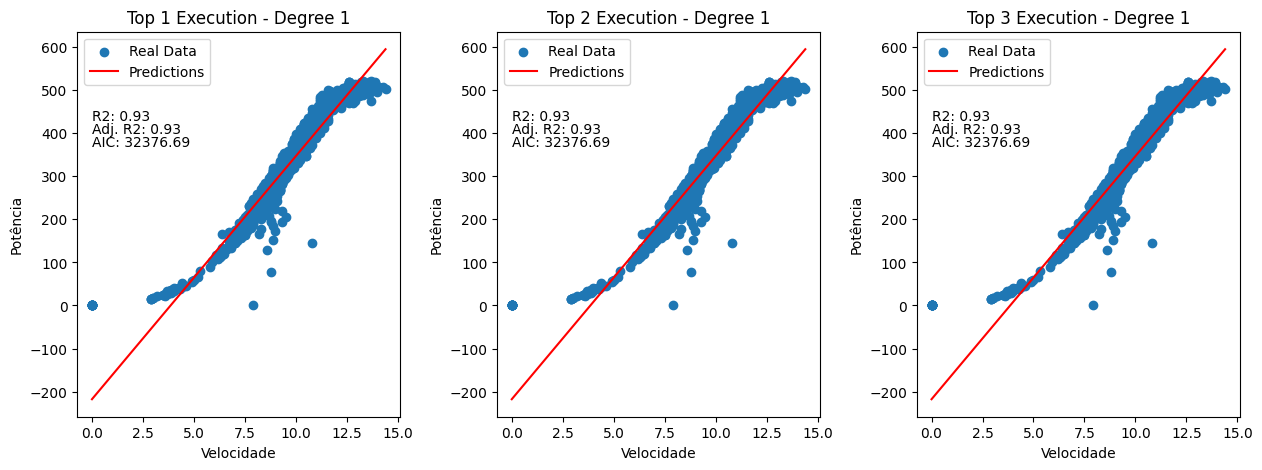

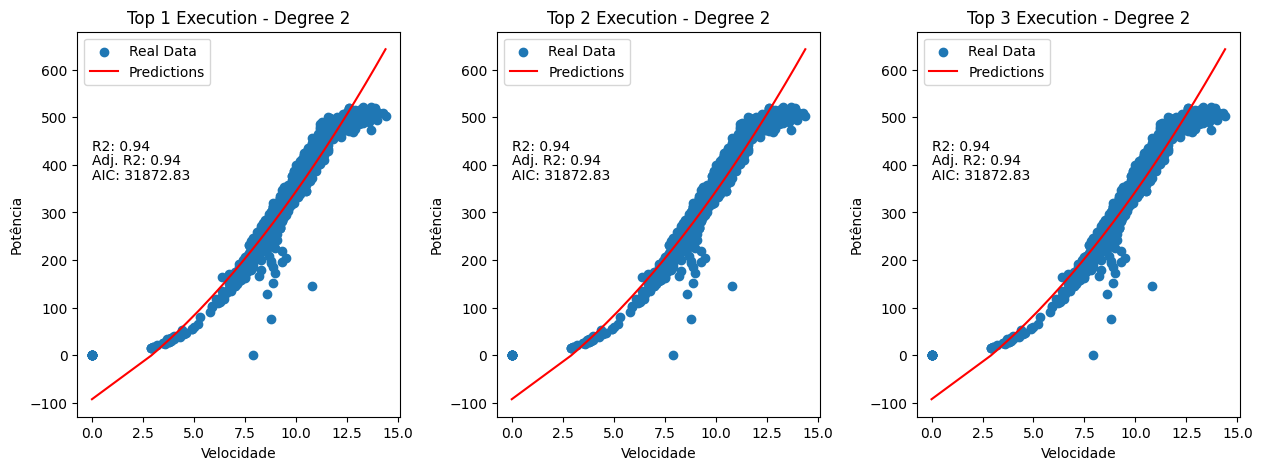

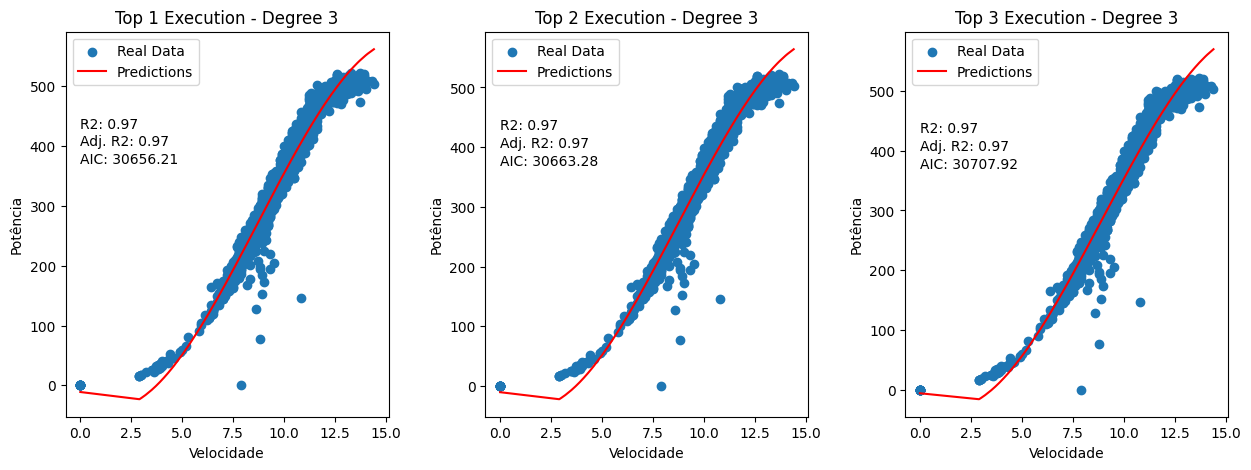

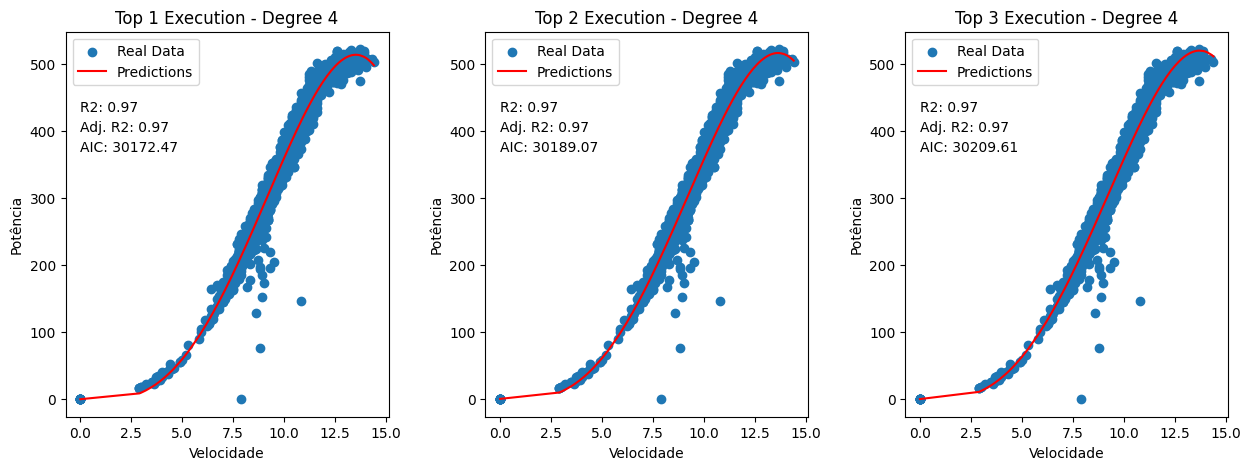

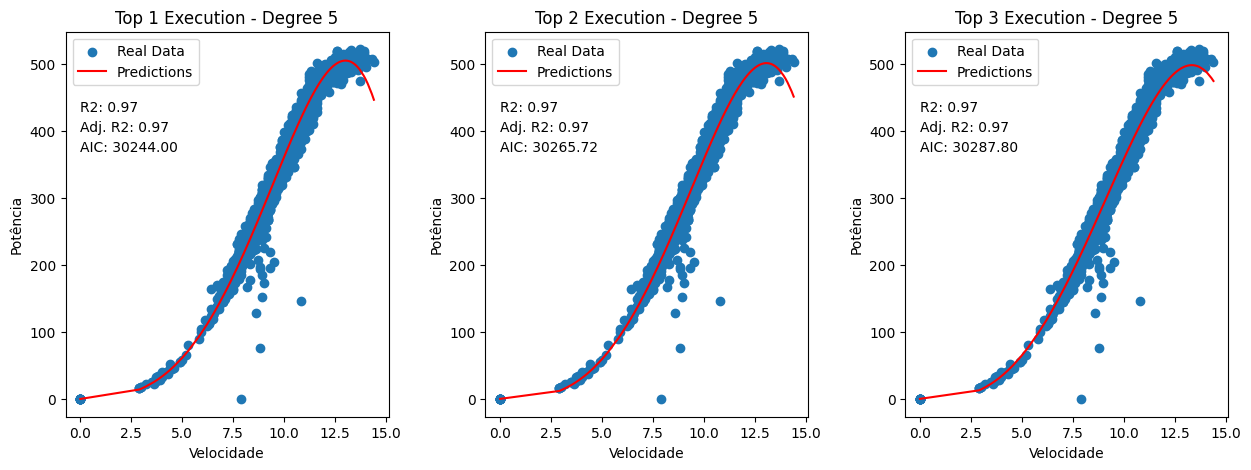

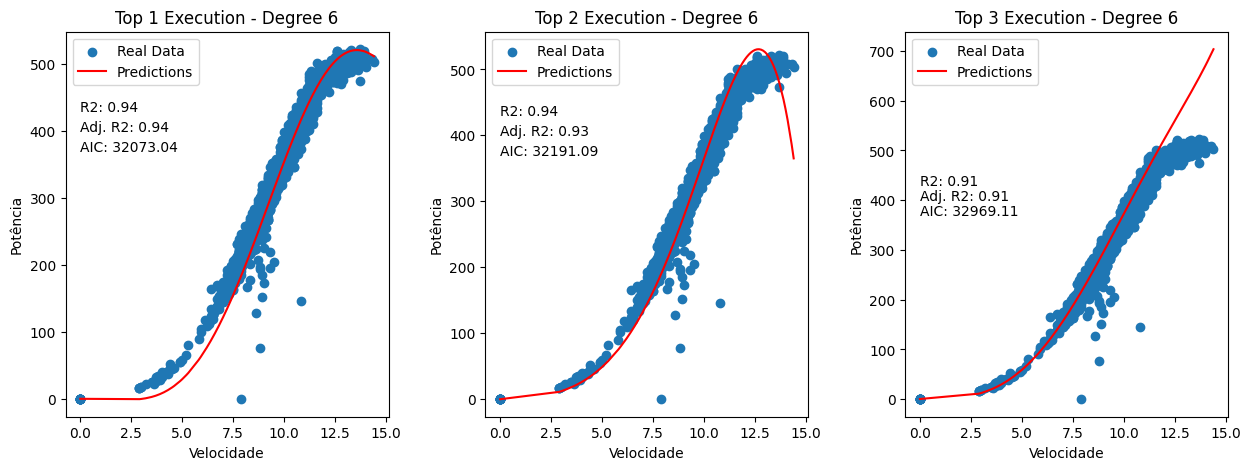

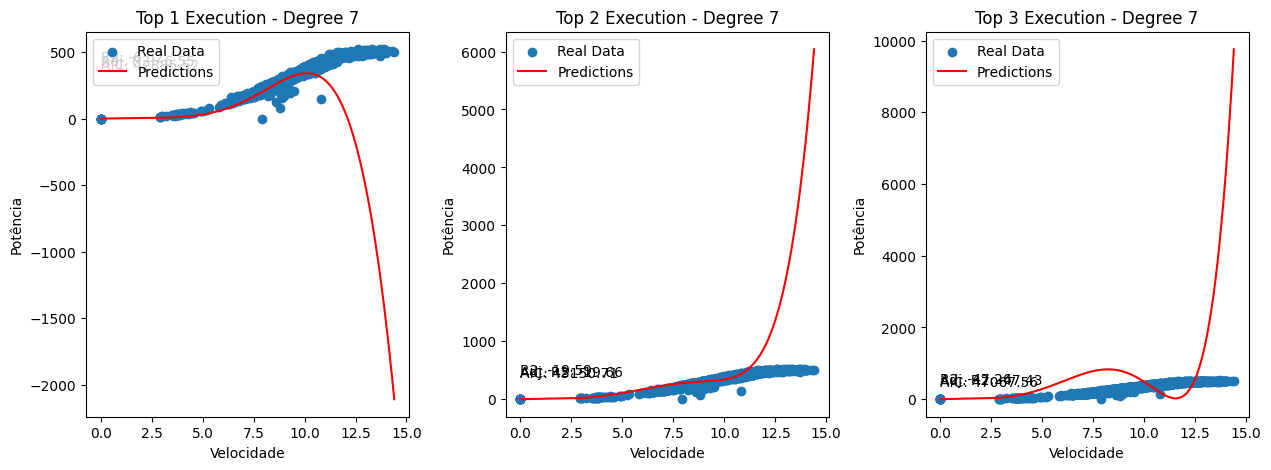

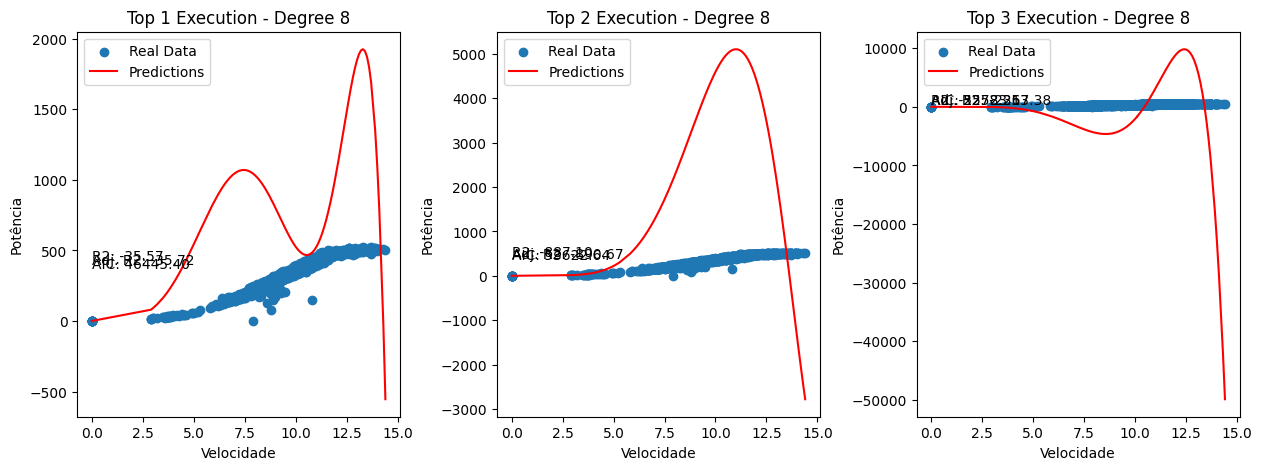

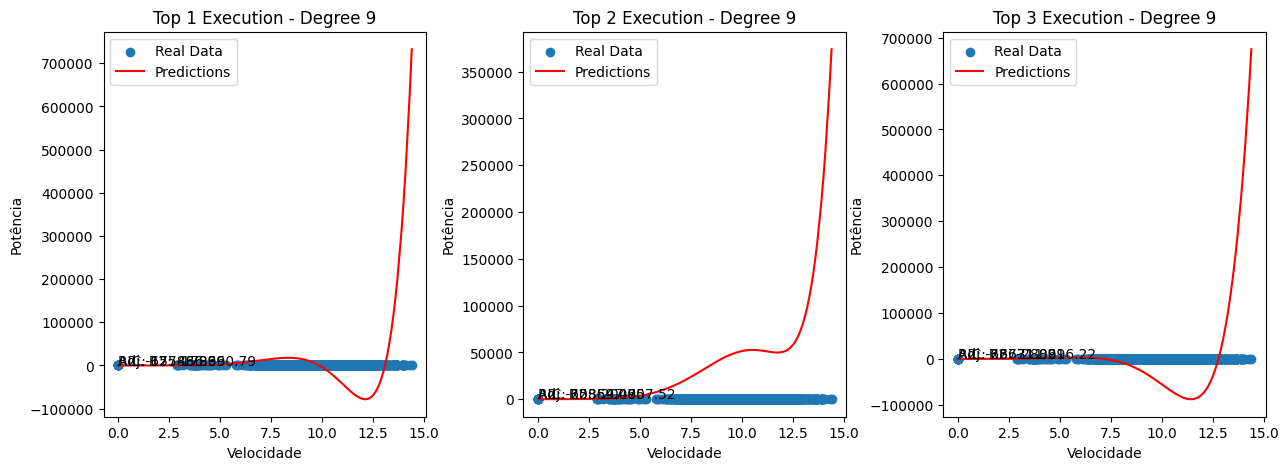

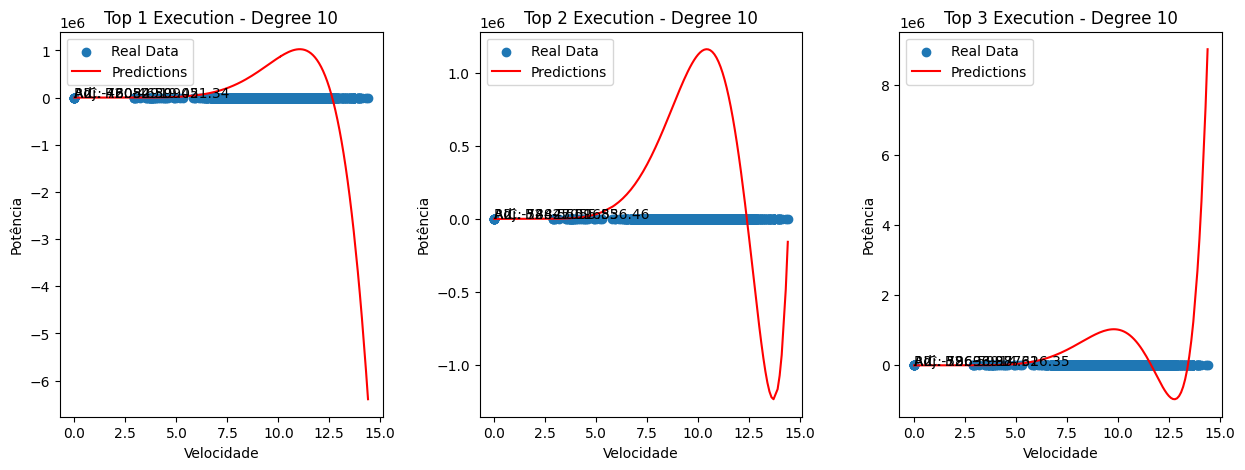

In [5]:
for degree, models in enumerate(best_models):
    r2s_list, coeffs_list, adj_r2s_list, aics_list = zip(*models)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    X = polynomial_matrix(degree + 1, vel)
    y = Pot.reshape(-1, 1)

    for i in range(3):
        coefficients = coeffs_list[i]
        y_pred = X @ coefficients
        
        sorted_order = np.argsort(X[:, 1])
        X_sorted = X[sorted_order]
        y_pred_sorted = y_pred[sorted_order]
        
        axes[i].scatter(X[:, 1], y, label='Real Data')
        axes[i].plot(X_sorted[:, 1], y_pred_sorted, color='red', label='Predictions')
        axes[i].set_title("Top {} Execution - Degree {}".format(i+1, degree+1))
        axes[i].set_xlabel('Velocidade')
        axes[i].set_ylabel('Potência')
        # axes[i].set_xlim(-1, 15)
        # axes[i].set_ylim(-100, 600)
        axes[i].text(0, 430, 'R2: {:.2f}'.format(r2s_list[i]))
        axes[i].text(0, 400, 'Adj. R2: {:.2f}'.format(adj_r2s_list[i]))
        axes[i].text(0, 370, 'AIC: {:.2f}'.format(aics_list[i]))
        axes[i].legend()

    plt.subplots_adjust(wspace=0.3)
    plt.show()